In [230]:
import folium
import geopy # объединенное API для популярных гео-кодирующих сервисов
from geopy.geocoders import Yandex
from geopy.distance import geodesic, great_circle
import numpy as np

import shapely
import geopandas as gpd

import pandas as pd
import matplotlib.pyplot as plt

In [232]:
Zazhigina_API = 'ac011052-9b61-4651-a943-5619739afa55' #top-secret

In [233]:
yandex = Yandex(api_key  = Zazhigina_API)

Task 1

In [372]:
mipt = Point(55.602144, 37.346551)
kremlin = Point(55.752023, 37.6174994)

In [66]:
def get_geodesic_distance(city1, city2):#используя готовые функции
    town1 = (city1.x, city1.y)
    town2 = (city2.x, city2.y)
    return great_circle(town1, town2).kilometers

In [67]:
get_geodesic_distance(mipt, kremlin)

23.797849711505837

In [30]:
import math
def get_geodesic(city1, city2):#используя синус-верзус
    R = 6373.0
    lat1 = math.radians(city1.x)
    lat2 = math.radians(city2.x)
    lon1 = math.radians(city1.y)
    lon2 = math.radians(city2.y)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance
    

In [31]:
get_geodesic(mipt, kremlin)

23.805286762493523

Task 2

In [79]:
import random
big_moscow_districts = gpd.read_file('./big_moscow_districts.shp')

In [84]:
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 5)

In [85]:
def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    if kind == 'by_board':
        df = pd.DataFrame(columns = ['Polygon', 'Distance'])
        minimum = math.inf
        dist_list = []
        
        for i in polygons:
            for pt in MultiPoint(i.boundary.coords):
                for single in MultiPoint(polygon.boundary.coords):
                    dist = get_geodesic_distance(pt, single)
                    if dist < minimum:
                        minimum = dist
            dist_list.append(minimum)
        df['Distance'] = dist_list
        req = df.sort_values(by=['Distance']).head(k).index
        a = pd.DataFrame(columns = ['geometry'])
        a['geometry']  = [polygons[i] for i in req]
        a = gpd.GeoDataFrame(a, geometry = a['geometry'])
        return a
            
        
    elif kind == 'by_centroid':
        centers = [i.centroid for i in polygons] 
        center = polygon.centroid
        center_data = pd.DataFrame(columns = ['Center', 'Distance'])
        center_data['Center'] = centers
        dis = [get_geodesic_distance(center, i) for i in centers] 
        center_data['Distance'] = dis
        
        req = center_data.sort_values(by=['Distance']).head(k).index

        a = pd.DataFrame(columns = ['geometry'])
        a['FID'] = list(range(0, len([polygons[i] for i in req])))
        a['geometry']  = [polygons[i] for i in req]
        a = a[['FID', 'geometry']]
        a = gpd.GeoDataFrame(a, geometry = a['geometry'])
        return a
        
            
        
        

In [89]:
k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=3, kind='by_board')

In [90]:
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=3, kind='by_centroid')

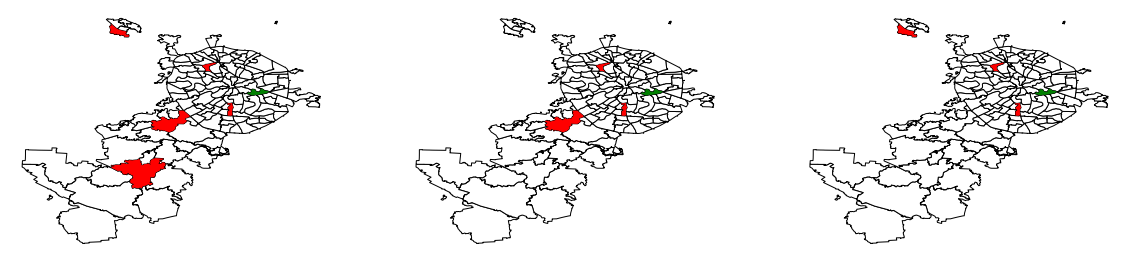

In [291]:
from descartes.patch import PolygonPatch
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 3, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()


ax = plt.subplot(1, 3, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
for k in polygons:
     gpd.GeoSeries(k).plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 3, 3)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

Task 3

In [99]:
grid_big_moscow = gpd.read_file('./grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

geometry  random_value
0      POLYGON ((37.03280 55.13974, 37.03280 55.14423...            16
1      POLYGON ((37.04064 55.13974, 37.04064 55.14423...            39
2      POLYGON ((37.04849 55.13974, 37.04849 55.14423...            15
3      POLYGON ((37.05633 55.13974, 37.05633 55.14423...            49
4      POLYGON ((37.02496 55.14423, 37.02496 55.14872...            51
...                                                  ...           ...
11032  POLYGON ((37.18962 56.01603, 37.18962 56.02062...            97
11033  POLYGON ((37.19746 56.01603, 37.19746 56.02062...            57
11034  POLYGON ((37.20530 56.01603, 37.20530 56.02062...            41
11035  POLYGON ((37.18178 56.02062, 37.18178 56.02521...            21
11036  POLYGON ((37.18962 56.02062, 37.18962 56.02521...            97

[11037 rows x 2 columns]

In [386]:
def spatial_resample(agg_polygons, init_polygons, method, column, kind='max'):
    values = pd.DataFrame(columns = ['geometry', column])
    container = []
    cur = []
    for i in agg_polygons['geometry']:
        for j in init_polygons.index:
            if kind == 'max':
                if (i.contains(init_polygons.iloc[j,0]) == True):
                    cur.append(init_polygons.loc[j][column])
            elif kind == 'prop':
                if (i.intersects(init_polygons.iloc[j,0]) == True):
                    cur.append((i.intersection(init_polygons.iloc[j,0])).area/init_polygons.iloc[j,0].area*init_polygons.iloc[j,1])
        if (method == 'sum'):
            container.append(sum(cur))
        elif (method == 'mean'):
            container.append(np.mean(cur))
        cur = []
    values[column] = container
    values['geometry'] = agg_polygons['geometry']
    
    values = gpd.GeoDataFrame(values, geometry = values['geometry'])
    values['index'] = range(0, len(agg_polygons))
    return values

In [323]:
mean_resample_table_prop = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='prop')

In [324]:
sum_resample_table_prop = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='prop')

In [328]:
mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max') 

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [388]:
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max') 

In [364]:
sum_resample_table.to_file("output.json", driver="GeoJSON")
big_moscow_districts.to_file("districts.json", driver="GeoJSON")
k_nearest_neighbours_by_centroid.to_file("centroid.json", driver="GeoJSON")
gpd.GeoSeries(polygon).to_file("polygon.json", driver="GeoJSON")
k_nearest_neighbours_by_board.to_file("board.json", driver="GeoJSON")

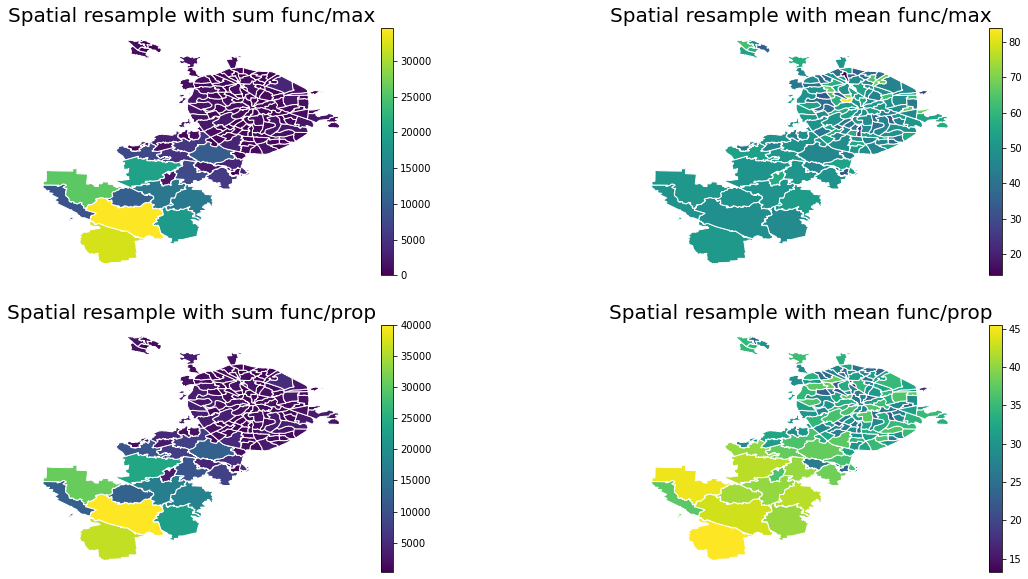

In [369]:
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(2, 2, 1)
plt.title('Spatial resample with sum func/max', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(2, 2, 2)
plt.title('Spatial resample with mean func/max', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(2, 2, 3)
plt.title('Spatial resample with sum func/prop', fontsize=20)
sum_resample_table_prop.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(2, 2, 4)
plt.title('Spatial resample with mean func/prop', fontsize=20)
mean_resample_table_prop.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()


Task 4

In [365]:
import json
from folium.features import DivIcon

with open('./districts.json', encoding='utf-8', mode='r') as json_file:
    district_polygon = json.load(json_file)
with open('./centroid.json', encoding='utf-8', mode='r') as json_file:
    cent = json.load(json_file)
with open('./polygon.json', encoding='utf-8', mode='r') as json_file:
    poly = json.load(json_file)
with open('./board.json', encoding='utf-8', mode='r') as json_file:
    board = json.load(json_file)
    
m = folium.Map(location=[55.755826, 37.6172999], # Москва
            zoom_start=7)

m.choropleth(
geo_data=district_polygon,
fill_color = 'white',
fill_opacity=0.7,
line_opacity=0.2
)
m.choropleth(
geo_data=cent,
fill_color = 'red',
fill_opacity=0.7,
line_opacity=0.2
)
m.choropleth(
geo_data=poly,
fill_color = 'green',
fill_opacity=0.7,
line_opacity=0.2
)

folium.LayerControl().add_to(m)
 

folium.map.Marker(
    [55.755826, 37.6172999],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:green"> Москва </div>',
        )
    ).add_to(m)


m

In [299]:
m = folium.Map(location=[55.755826, 37.6172999], # Москва
            zoom_start=7)

m.choropleth(
geo_data=district_polygon,
fill_color = 'white',
fill_opacity=0.7,
line_opacity=0.2
)
m.choropleth(
geo_data=board,
fill_color = 'red',
fill_opacity=0.7,
line_opacity=0.2
)
m.choropleth(
geo_data=poly,
fill_color = 'green',
fill_opacity=0.7,
line_opacity=0.2
)

folium.LayerControl().add_to(m)
 

folium.map.Marker(
    [55.755826, 37.6172999],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:green"> Москва </div>',
        )
    ).add_to(m)


m

In [382]:
import json
from folium.features import DivIcon

with open('./output.json', encoding='utf-8', mode='r') as json_file:
    moscow_polygon = json.load(json_file)

m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=7)
m.choropleth(
geo_data=moscow_polygon,
data=sum_resample_table,
columns=['index','random_value' ],
fill_color = 'RdBu_r',
key_on='feature.properties.index',
fill_opacity=0.7,
line_opacity=0.2
)

folium.LayerControl().add_to(m)
 


folium.map.Marker(
    [55.755826, 37.6172999],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:black"> Москва </div>',
        )
    ).add_to(m)


m